In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
import math
from torch.utils.tensorboard import SummaryWriter
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 18})

In [2]:
features = np.load(f'DataSet/Features_Diff_1.npz')['Features_Diff_1']
print(features.shape)

(151839, 71, 8)


In [3]:
data = features[0:90000]

In [4]:
input_window = 47
output_window = 24

# 用来存储输入和输出的列表
inputs = []
outputs = []

# 为了确保没有超出数组的界限，我们创建一个循环，截止到可以完整提取一个输入加一个输出的位置
for i in range(data.shape[1] - input_window - output_window + 1):
    # 对每一个样本处理
    for sample in data:
        inputs.append(sample[i:i + input_window])
        outputs.append(sample[i + input_window: i + input_window + output_window])

inputs = np.array(inputs)
outputs = np.array(outputs)

# 转换为torch.Tensor
inputs_tensor = torch.from_numpy(inputs).float()
outputs_tensor = torch.from_numpy(outputs).float()

# 划分训练集和测试集
num_samples = inputs_tensor.shape[0]
train_size = int(num_samples * 0.8)

train_inputs = inputs_tensor[:train_size]
train_outputs = outputs_tensor[:train_size]
test_inputs = inputs_tensor[train_size:]
test_outputs = outputs_tensor[train_size:]

# 创建数据集和数据加载器
train_dataset = TensorDataset(train_inputs, train_outputs)
train_loader = DataLoader(train_dataset, batch_size=180, shuffle=True, num_workers=16, pin_memory=True)

test_dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(test_dataset, batch_size=180, shuffle=False, num_workers=16, pin_memory=True)

# 验证输出形状
print("Train inputs shape:", train_inputs.shape)
print("Train outputs shape:", train_outputs.shape)
print("Test inputs shape:", test_inputs.shape)
print("Test outputs shape:", test_outputs.shape)

Train inputs shape: torch.Size([72000, 47, 8])
Train outputs shape: torch.Size([72000, 24, 8])
Test inputs shape: torch.Size([18000, 47, 8])
Test outputs shape: torch.Size([18000, 24, 8])


In [5]:
import torch
import torch.nn as nn
import numpy as np

class ProbSparseAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_k = d_model // num_heads
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        
    def forward(self, q, k, v, mask=None):
        # 分头计算
        batch_size = q.size(0)
        q = self.query(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.key(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.value(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # 计算注意力得分
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attn = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn, v).transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return output

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)  # 假设输出大小与输入大小相同

    def forward(self, x, hidden, cell):
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        
        prediction = self.fc(output)
        return prediction, hidden, cell


class Informer(nn.Module):
    def __init__(self, input_dim, output_dim, seq_len, pred_len, d_model, num_heads):
        super().__init__()
        self.attention = ProbSparseAttention(d_model, num_heads)
        self.encoder = Encoder(input_dim, d_model)
        self.decoder = Decoder(d_model, d_model)
        self.fc = nn.Linear(d_model, input_dim)
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def forward(self, x):
        output, hidden, cell = self.encoder(x)
        output = self.attention(output, output, output)
        output, _, _ = self.decoder(output, hidden, cell)
        decoded = self.fc(output[:, -self.pred_len:, :])
        return decoded

In [6]:
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    total_loss = 0
    # Wrap the data_loader with tqdm for a progress bar
    progress_bar = tqdm(data_loader, desc='Training', leave=True)
    for src, tgt in progress_bar:
        src, tgt_output = src.to(device), tgt.to(device)
        optimizer.zero_grad()  # Clear gradients
        output = model(src)    # Forward pass
        loss = criterion(output, tgt_output)  # Compute loss
        # clip_grad_norm_(model.parameters(), max_norm=0.01)  # Gradient clipping
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters
        total_loss += loss.item()
        # Update the progress bar with the latest loss
        progress_bar.set_postfix({'loss': loss.item()})
        
    average_loss = total_loss / len(data_loader)
    return average_loss

def validate_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt_output = src.to(device), tgt.to(device)
            output = model(src)
            loss = criterion(output, tgt_output)
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [7]:
# 模型参数
input_dim = 8  # 输入特征维度
output_dim = 8  # 输出特征维度
seq_len = 47   # 输入序列长度
pred_len = 24  # 预测序列长度
d_model = 512  # 模型维度
num_heads = 8  # 注意力头数

model = Informer(input_dim, output_dim, seq_len, pred_len, d_model, num_heads)


In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.MSELoss()

In [12]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
    #     torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # 假设使用ReLU激活函数
    #     if m.bias is not None:
        m.bias.data.fill_(0.01)

model.apply(init_weights)

Informer(
  (attention): ProbSparseAttention(
    (query): Linear(in_features=512, out_features=512, bias=True)
    (key): Linear(in_features=512, out_features=512, bias=True)
    (value): Linear(in_features=512, out_features=512, bias=True)
  )
  (encoder): Encoder(
    (lstm): LSTM(8, 512, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(512, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=512, bias=True)
  )
  (fc): Linear(in_features=512, out_features=8, bias=True)
)

In [16]:
import hiddenlayer as hl

graph = hl.build_graph(model, torch.zeros([180, 47, 8]))  # 输入数据的形状应与模型期望的输入匹配
graph.theme = hl.graph.THEMES['blue'].copy()  # 选择一个主题
graph.save('model_visualization.png', format='png')

NotImplementedError: Could not run 'aten::mkldnn_rnn_layer' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::mkldnn_rnn_layer' is only available for these backends: [CPU, Meta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMeta, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

CPU: registered at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen\RegisterCPU.cpp:31034 [kernel]
Meta: registered at /dev/null:241 [kernel]
BackendSelect: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:144 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\DynamicLayer.cpp:491 [backend fallback]
Functionalize: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\FunctionalizeFallbackKernel.cpp:280 [backend fallback]
Named: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\VariableFallbackKernel.cpp:63 [backend fallback]
AutogradOther: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradCPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradCUDA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradHIP: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradXLA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradMPS: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradIPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradXPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradHPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradVE: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradLazy: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradMeta: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradMTIA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradPrivateUse1: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradPrivateUse2: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradPrivateUse3: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
AutogradNestedTensor: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17488 [autograd kernel]
Tracer: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\TraceType_2.cpp:16726 [kernel]
AutocastCPU: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\autocast_mode.cpp:492 [kernel]
AutocastCUDA: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\autocast_mode.cpp:354 [backend fallback]
FuncTorchBatched: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:815 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\LegacyBatchingRegistrations.cpp:1073 [backend fallback]
VmapMode: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:152 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\DynamicLayer.cpp:487 [backend fallback]
PythonDispatcher: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:148 [backend fallback]


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
num_epochs = 50
writer = SummaryWriter(log_dir='runs/Informer')
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    writer.add_scalar('Loss/train', train_loss, epoch)
    val_loss = validate_epoch(model, test_loader, criterion, device)
    writer.add_scalar('Loss/val', val_loss, epoch)    
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")
writer.close()

cuda


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Training: 100%|██████████| 400/400 [00:37<00:00, 10.53it/s, loss=0.0555]


Epoch 1: Train Loss = 0.0683, Validation Loss = 0.0420


Training: 100%|██████████| 400/400 [00:22<00:00, 17.44it/s, loss=0.0767]


Epoch 2: Train Loss = 0.0460, Validation Loss = 0.0381


Training: 100%|██████████| 400/400 [00:23<00:00, 17.16it/s, loss=0.0405]


Epoch 3: Train Loss = 0.0390, Validation Loss = 0.0276


Training: 100%|██████████| 400/400 [00:23<00:00, 16.97it/s, loss=0.0486]


Epoch 4: Train Loss = 0.0323, Validation Loss = 0.0276


Training: 100%|██████████| 400/400 [00:24<00:00, 16.03it/s, loss=0.0225]


Epoch 5: Train Loss = 0.0367, Validation Loss = 0.0291


Training: 100%|██████████| 400/400 [00:23<00:00, 16.90it/s, loss=0.0201] 


Epoch 6: Train Loss = 0.0289, Validation Loss = 0.0236


Training: 100%|██████████| 400/400 [00:25<00:00, 15.49it/s, loss=0.0221] 


Epoch 7: Train Loss = 0.0334, Validation Loss = 0.0334


Training: 100%|██████████| 400/400 [00:24<00:00, 16.52it/s, loss=0.022] 


Epoch 8: Train Loss = 0.0325, Validation Loss = 0.0296


Training: 100%|██████████| 400/400 [00:23<00:00, 16.95it/s, loss=0.0317] 


Epoch 9: Train Loss = 0.0274, Validation Loss = 0.0232


Training: 100%|██████████| 400/400 [00:25<00:00, 15.53it/s, loss=0.0535]


Epoch 10: Train Loss = 0.0395, Validation Loss = 0.0314


Training: 100%|██████████| 400/400 [00:25<00:00, 15.46it/s, loss=0.0549]


Epoch 11: Train Loss = 0.0688, Validation Loss = 0.0609


Training: 100%|██████████| 400/400 [00:27<00:00, 14.74it/s, loss=0.0563]


Epoch 12: Train Loss = 0.0728, Validation Loss = 0.0614


Training: 100%|██████████| 400/400 [00:23<00:00, 16.75it/s, loss=0.0415]


Epoch 13: Train Loss = 0.0562, Validation Loss = 0.0466


Training: 100%|██████████| 400/400 [00:27<00:00, 14.47it/s, loss=0.0364]


Epoch 14: Train Loss = 0.0479, Validation Loss = 0.0419


Training: 100%|██████████| 400/400 [00:24<00:00, 16.35it/s, loss=0.029] 


Epoch 15: Train Loss = 0.0460, Validation Loss = 0.0398


Training: 100%|██████████| 400/400 [00:29<00:00, 13.44it/s, loss=0.0322]


Epoch 16: Train Loss = 0.0445, Validation Loss = 0.0391


Training: 100%|██████████| 400/400 [00:22<00:00, 17.49it/s, loss=0.0288]


Epoch 17: Train Loss = 0.0438, Validation Loss = 0.0391


Training: 100%|██████████| 400/400 [00:23<00:00, 17.37it/s, loss=0.0244]


Epoch 18: Train Loss = 0.0429, Validation Loss = 0.0375


Training: 100%|██████████| 400/400 [00:22<00:00, 17.93it/s, loss=0.0309]


Epoch 19: Train Loss = 0.0424, Validation Loss = 0.0385


Training: 100%|██████████| 400/400 [00:22<00:00, 18.07it/s, loss=0.0337]


Epoch 20: Train Loss = 0.0416, Validation Loss = 0.0371


Training: 100%|██████████| 400/400 [00:23<00:00, 17.11it/s, loss=0.0269]


Epoch 21: Train Loss = 0.0408, Validation Loss = 0.0362


Training: 100%|██████████| 400/400 [00:23<00:00, 17.12it/s, loss=0.0544]


Epoch 22: Train Loss = 0.0404, Validation Loss = 0.0362


Training: 100%|██████████| 400/400 [00:21<00:00, 18.22it/s, loss=0.0223]


Epoch 23: Train Loss = 0.0393, Validation Loss = 0.0349


Training: 100%|██████████| 400/400 [00:22<00:00, 17.61it/s, loss=0.0622]


Epoch 24: Train Loss = 0.0398, Validation Loss = 0.0494


Training: 100%|██████████| 400/400 [00:22<00:00, 17.97it/s, loss=0.0514]


Epoch 25: Train Loss = 0.0421, Validation Loss = 0.0355


Training: 100%|██████████| 400/400 [00:22<00:00, 17.83it/s, loss=0.025] 


Epoch 26: Train Loss = 0.0380, Validation Loss = 0.0343


Training: 100%|██████████| 400/400 [00:24<00:00, 16.66it/s, loss=0.0374]


Epoch 27: Train Loss = 0.0371, Validation Loss = 0.0329


Training: 100%|██████████| 400/400 [00:22<00:00, 18.18it/s, loss=0.0549]


Epoch 28: Train Loss = 0.0499, Validation Loss = 0.0383


Training: 100%|██████████| 400/400 [00:22<00:00, 17.82it/s, loss=0.0283]


Epoch 29: Train Loss = 0.0406, Validation Loss = 0.0374


Training: 100%|██████████| 400/400 [00:24<00:00, 16.62it/s, loss=0.0373]


Epoch 30: Train Loss = 0.0377, Validation Loss = 0.0335


Training: 100%|██████████| 400/400 [00:22<00:00, 17.84it/s, loss=0.054] 


Epoch 31: Train Loss = 0.0357, Validation Loss = 0.0325


Training: 100%|██████████| 400/400 [00:22<00:00, 17.77it/s, loss=0.034] 


Epoch 32: Train Loss = 0.0341, Validation Loss = 0.0300


Training: 100%|██████████| 400/400 [00:23<00:00, 16.75it/s, loss=0.0178]


Epoch 33: Train Loss = 0.0323, Validation Loss = 0.0306


Training: 100%|██████████| 400/400 [00:22<00:00, 17.67it/s, loss=0.0208]


Epoch 34: Train Loss = 0.0307, Validation Loss = 0.0279


Training: 100%|██████████| 400/400 [00:22<00:00, 17.74it/s, loss=0.032] 


Epoch 35: Train Loss = 0.0281, Validation Loss = 0.0260


Training: 100%|██████████| 400/400 [00:24<00:00, 16.63it/s, loss=0.0357]


Epoch 36: Train Loss = 0.0343, Validation Loss = 0.0315


Training: 100%|██████████| 400/400 [00:22<00:00, 17.76it/s, loss=0.024]  


Epoch 37: Train Loss = 0.0289, Validation Loss = 0.0251


Training: 100%|██████████| 400/400 [00:24<00:00, 16.64it/s, loss=0.0306]


Epoch 38: Train Loss = 0.0264, Validation Loss = 0.0252


Training: 100%|██████████| 400/400 [00:25<00:00, 15.76it/s, loss=0.0168]


Epoch 39: Train Loss = 0.0255, Validation Loss = 0.0235


Training: 100%|██████████| 400/400 [00:23<00:00, 17.22it/s, loss=0.0237]


Epoch 40: Train Loss = 0.0255, Validation Loss = 0.0240


Training: 100%|██████████| 400/400 [00:22<00:00, 17.70it/s, loss=0.0342] 


Epoch 41: Train Loss = 0.0243, Validation Loss = 0.0237


Training: 100%|██████████| 400/400 [00:23<00:00, 16.94it/s, loss=0.00943]


Epoch 42: Train Loss = 0.0230, Validation Loss = 0.0216


Training: 100%|██████████| 400/400 [00:24<00:00, 16.48it/s, loss=0.0262] 


Epoch 43: Train Loss = 0.0225, Validation Loss = 0.0220


Training: 100%|██████████| 400/400 [00:25<00:00, 15.88it/s, loss=0.0156] 


Epoch 44: Train Loss = 0.0225, Validation Loss = 0.0214


Training: 100%|██████████| 400/400 [00:22<00:00, 17.70it/s, loss=0.021]  


Epoch 45: Train Loss = 0.0220, Validation Loss = 0.0204


Training: 100%|██████████| 400/400 [00:22<00:00, 17.82it/s, loss=0.0185] 


Epoch 46: Train Loss = 0.0214, Validation Loss = 0.0226


Training: 100%|██████████| 400/400 [00:22<00:00, 17.89it/s, loss=0.017]  


Epoch 47: Train Loss = 0.0213, Validation Loss = 0.0211


Training: 100%|██████████| 400/400 [00:22<00:00, 17.93it/s, loss=0.016]  


Epoch 48: Train Loss = 0.0214, Validation Loss = 0.0209


Training: 100%|██████████| 400/400 [00:23<00:00, 16.82it/s, loss=0.0289] 


Epoch 49: Train Loss = 0.0207, Validation Loss = 0.0213


Training: 100%|██████████| 400/400 [00:22<00:00, 17.62it/s, loss=0.0156] 


Epoch 50: Train Loss = 0.0207, Validation Loss = 0.0207


In [27]:
torch.save(model.state_dict(), 'Model_Path/Informer.pth')

In [8]:
model = Informer(input_dim, output_dim, seq_len, pred_len, d_model, num_heads)
model.load_state_dict(torch.load('Model_Path/Informer.pth'))

<All keys matched successfully>

torch.Size([1, 24, 8])


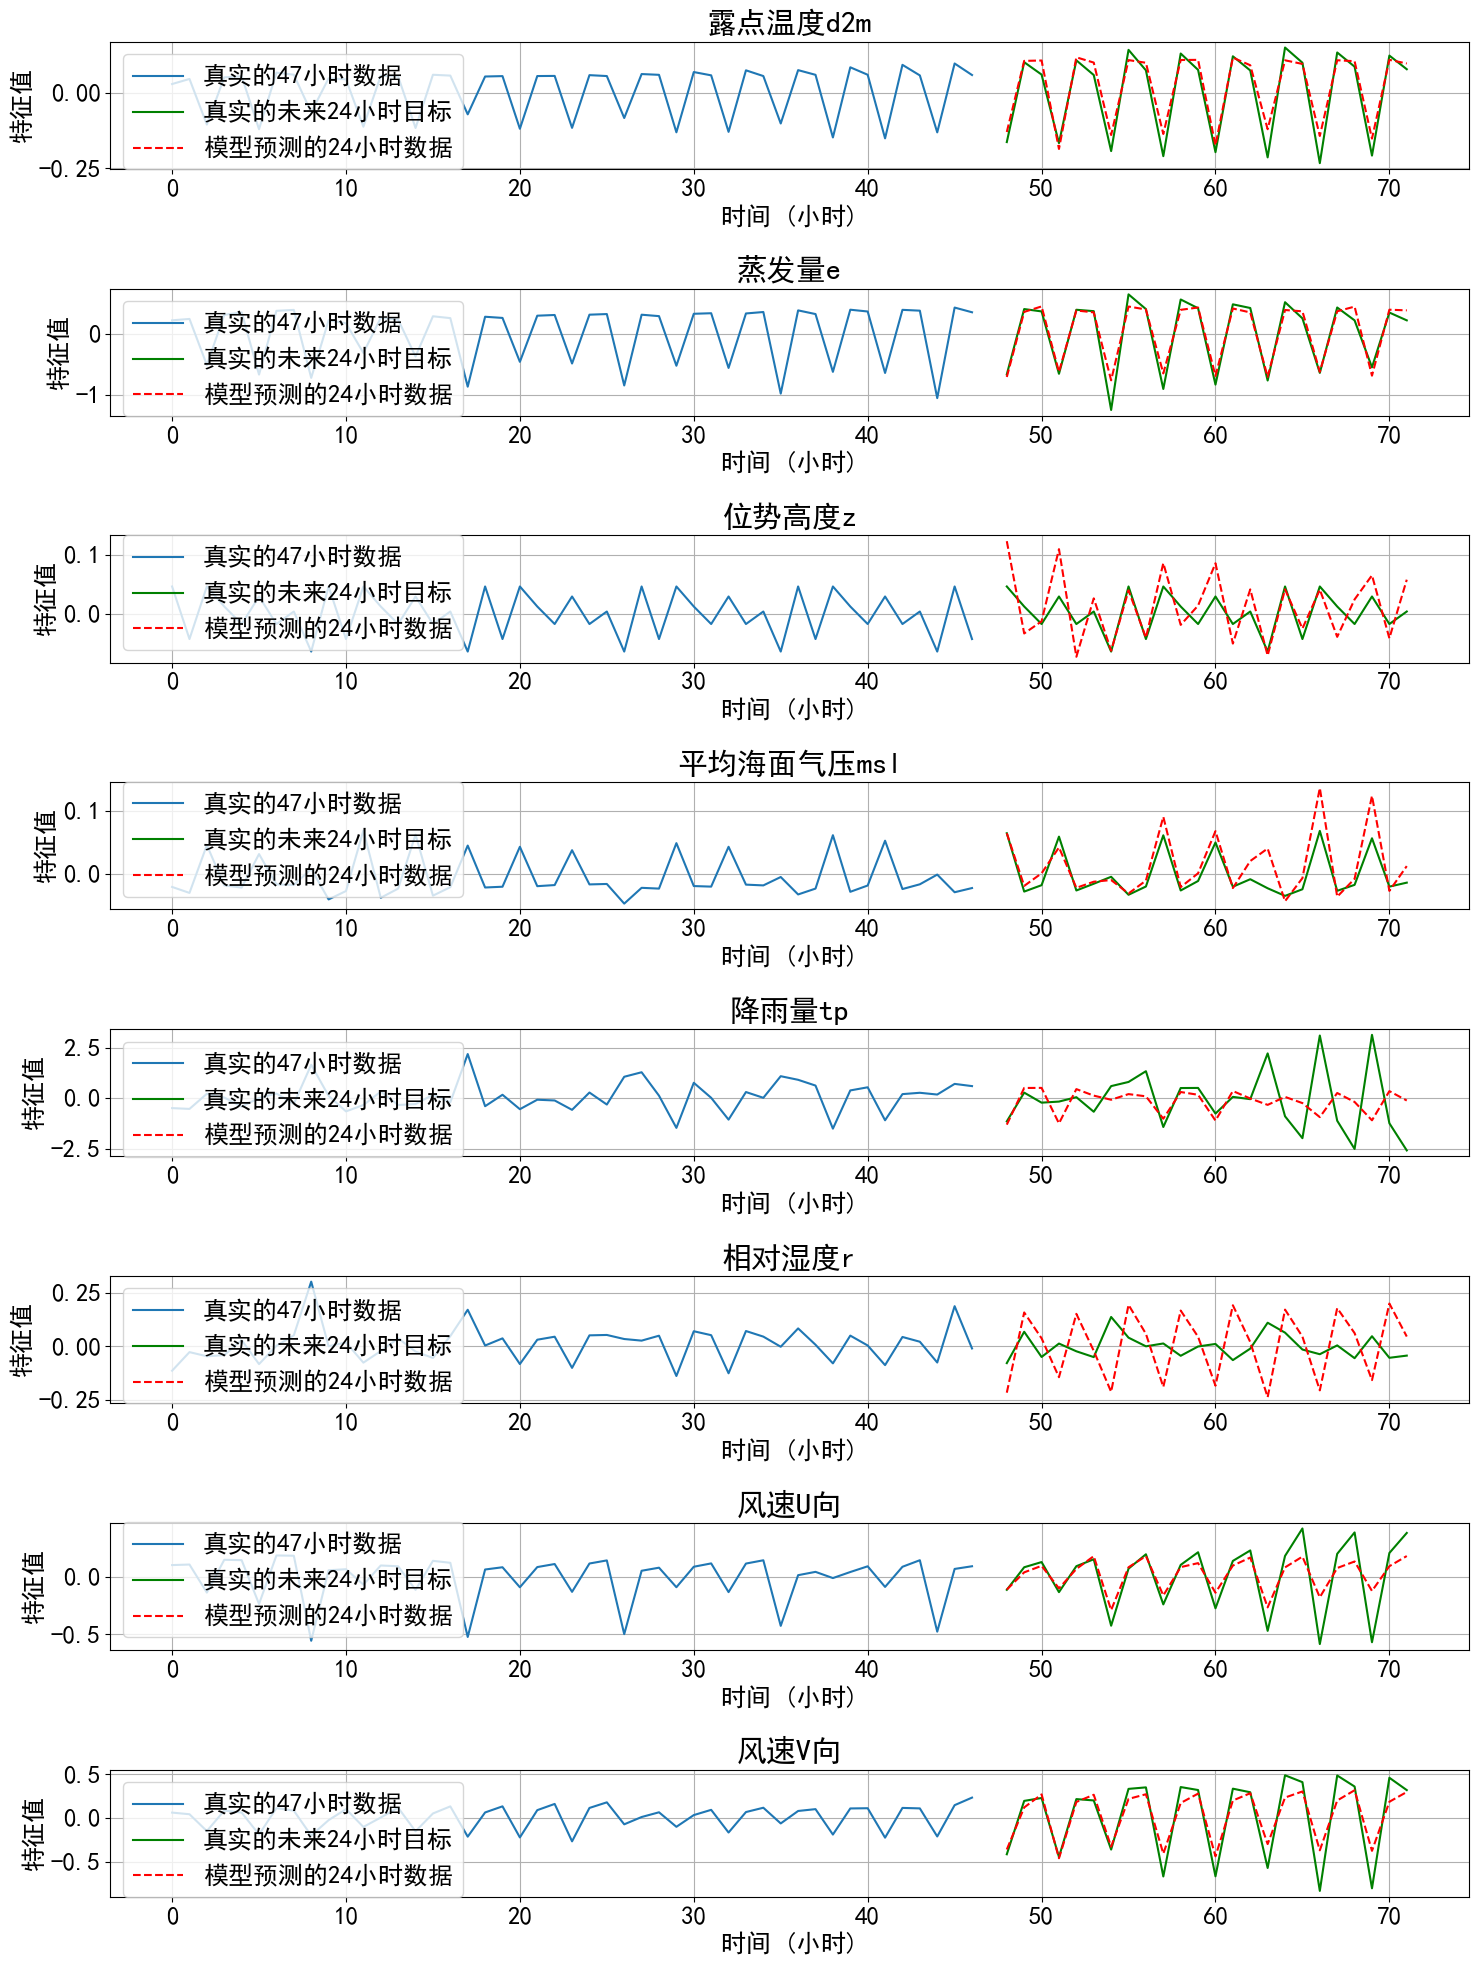

In [9]:
Num_Feature = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
variable_names = ['露点温度d2m', '蒸发量e','位势高度z','平均海面气压msl', '降雨量tp','相对湿度r','风速U向','风速V向']
def evaluate_and_plot_features(model, test_loader):
    for batch in test_loader:
        inputs, targets = batch
        model = model.to(device)
        inputs = inputs.to(device)
        output = model(inputs)
        # 选择第一个样本
        single_input = inputs[0:1].to(device)
        single_target = targets[0:1].to(device)
        output = output[0:1].to(device)
        break  # 只处理第一个batch
    # 将数据移回CPU以便打印或进一步处理
    print(output.shape)

    
    single_input = single_input.cpu().view(-1, Num_Feature)
    single_target = single_target.cpu().view(-1, Num_Feature)
    output = output.cpu().view(-1, Num_Feature)

    # 绘制每个特征的图表
    num_features = Num_Feature
    plt.figure(figsize=(15, 20))
    for i in range(num_features):
        plt.subplot(num_features, 1, i+1)
        plt.plot(single_input[:, i], label='真实的47小时数据')
        plt.plot(range(48, 72), single_target[:, i], 'g', label='真实的未来24小时目标')
        plt.plot(range(48, 72), output[:, i].detach().numpy(), 'r--', label='模型预测的24小时数据')
        plt.title(variable_names[i])
        plt.xlabel('时间 (小时)')
        plt.ylabel(f'特征值')
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

# 调用函数
evaluate_and_plot_features(model, test_loader)